In [17]:
from cfe import regression as regression_tools
import numpy as np
import matplotlib.pyplot as plt
from nutrition_results import r as uga
from nutrition_results import rdi, nutrient_demand
from nutrition_results import pbar

In [18]:
r = regression_tools.read_pickle('my_result.pickle')
uganda_predicted_expenditures = r.predicted_expenditures()
uganda_predicted_prices = np.exp(r.get_Ar())

In [19]:
uganda_reference_prices = uganda_predicted_prices.xs("2019-20", level='t').groupby('j').mean()

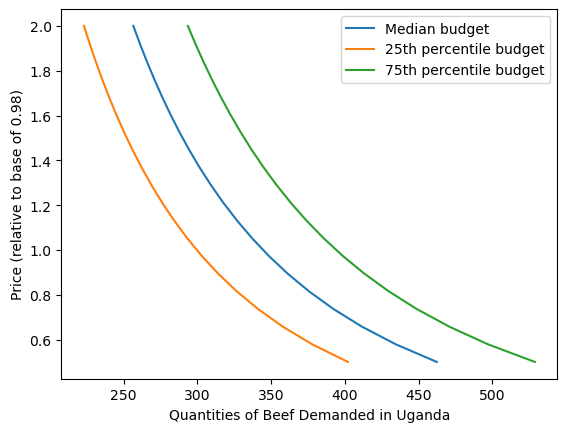

In [20]:
food = 'Beef'
uganda_price_scale = np.linspace(0.5, 2, 20)
uganda_total_expenditures = uganda_predicted_expenditures.groupby(['i', 't', 'm']).sum()
uganda_median_budget = uganda_total_expenditures.quantile(0.5)
uganda_reference_prices = uganda_predicted_prices.xs("2019-20", level='t').groupby('j').mean()  # Replace 'latest_year' with the actual latest year available, e.g., '2019'

def adjust_uganda_prices(new_price, prices=uganda_reference_prices, good=food):
    adjusted_prices = prices.copy()
    adjusted_prices.loc[good] = new_price
    return adjusted_prices
plt.plot(
    [r.demands(uganda_median_budget, adjust_uganda_prices(uganda_reference_prices[food] * scale))[food] for scale in uganda_price_scale],
    uganda_price_scale,
    label='Median budget'
)
plt.plot(
    [r.demands(uganda_total_expenditures.quantile(0.25), adjust_uganda_prices(uganda_reference_prices[food] * scale))[food] for scale in uganda_price_scale],
    uganda_price_scale,
    label='25th percentile budget'
)
plt.plot(
    [r.demands(uganda_total_expenditures.quantile(0.75), adjust_uganda_prices(uganda_reference_prices[food] * scale))[food] for scale in uganda_price_scale],
    uganda_price_scale,
    label='75th percentile budget'
)

plt.ylabel(f"Price (relative to base of {uganda_reference_prices[food]:.2f})")
plt.xlabel(f"Quantities of {food} Demanded in Uganda")
plt.legend()
plt.show()

In [21]:
xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)

Text(0.5, 1.0, 'Engel Curves')

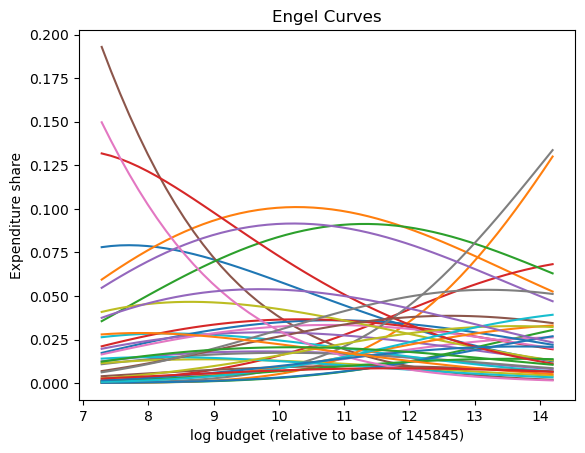

In [22]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

In [23]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')
qhat = qhat.loc[:,qhat.count()>0]

In [39]:
def my_prices(p0,p=pbar,food = 'Cabbages'):
    p = p.copy()
    p.loc[food] = p0
    return p

j
Beans              3952.083333
Beef              10500.000000
Biscuits           2750.000000
Bread              4625.000000
Cabbages           2349.147731
Cassava            1162.622549
Chapati            1750.000000
Cooking Oil        2060.984848
Dodo                958.333333
Eggs               1750.000000
Fish (dried)       2990.303510
Fish (fresh)       4224.050725
Goat              11000.000000
Ground Nuts        5607.965686
Maize              2073.775054
Mangos              607.477121
Matoke             1556.997715
Milk (fresh)       2933.333333
Millet             3958.333333
Onions             1239.583333
Oranges             713.848039
Other Fruits       2741.789875
Other Veg.         1108.987403
Peas               5208.333333
Pork              10250.000000
Rice               3575.000000
Salt               1400.000000
Sim Sim           12454.166667
Soda               3333.333333
Sorghum            1625.000000
Sweet Bananas      1378.308824
Sweet Potatoes     1019.934641
Tea   

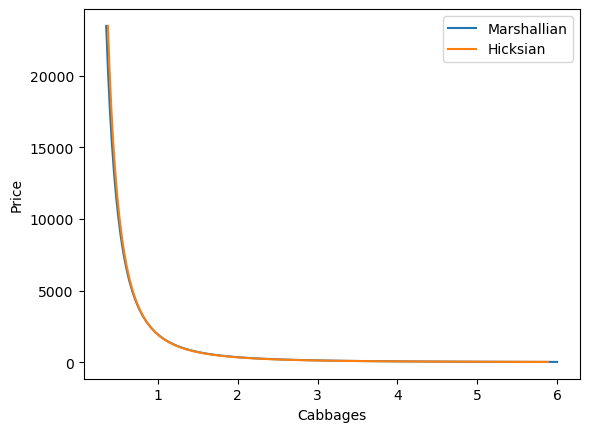

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Cabbages'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = uga.indirect_utility(x0,pbar)

plt.plot([uga.demands(x0,my_prices(p0,pbar,my_j))[my_j] for p0 in P],P)
plt.plot([uga.demands(U0,my_prices(p0,pbar,my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

In [ ]:
def compensating_variation(U0,p0,p1):
    x0 = uga.expenditure(U0,p0)
    x1 = uga.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = uga.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")